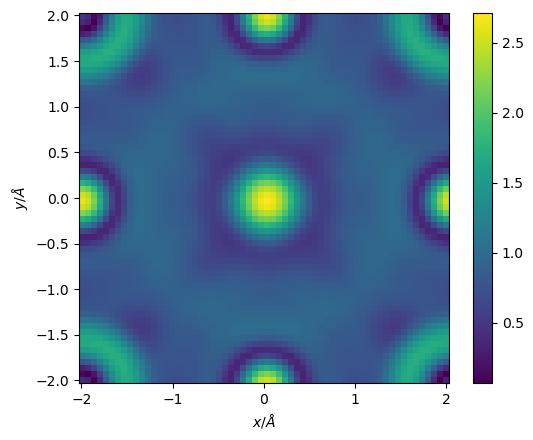

In [120]:
import numpy as np
from matplotlib import pyplot as plt
from ase import Atoms
import sys
sys.path.append("../Functions")
from structure_generator import (
    construction_periodic,
    set_dopants,
    construct_amorphous)
from GS_waves import select_freq_range
from abtem.waves import PlaneWave


#Construct periodic structure
a = 2.0247 * 2
Al = Atoms("Al4", cell=[a, a, a], pbc=(1, 1, 1), 
           scaled_positions=[(0, 0, 0), (0, 0.5, 0.5), (0.5, 0, 0.5), (0.5, 0.5, 0)])
energy = 300e3; sampling = 0.0656015; gmin = 0; gmax=1.5
structure = construction_periodic(Al, 1, 1, 20)

#constants irrelevant to thickness
#n = 20; A = a; h = a; gap = 0.0128; H = h*(n-1)
#results from pure Aluminum column
#structure = Atoms(f'Al{n}', positions=[(A/2, A/2, i*h + gap) for i in range(n)], cell=[A, A, H + gap])
ew = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                           gmin, gmax, sampling)
plt.imshow(np.abs(ew), extent=[-a/2, a/2, -a/2, a/2])
plt.xlabel(r"$x/\AA$")
plt.ylabel(r"$y/\AA$")
plt.colorbar()
plt.show()

In [125]:
from scipy.special import j0
from scipy.optimize import minimize
def Bessel_transform(func, sampling, kmin, kmax, length, x0=0, y0=0):
    results = []
    components = np.ones(func.shape)*(0+0j)
    krange = np.linspace(kmin, kmax, length)*np.pi*2
    m, n = func.shape; Area = m * n
    x = np.linspace(-sampling*m/2, sampling*m/2, m) - x0
    y = np.linspace(-sampling*n/2, sampling*n/2, n) - y0
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    for k in krange:
        y = np.sqrt(k) * j0(k * R) * func
        result = np.sum(y)*sampling**2
        results.append(result)
        components += result * np.sqrt(k) * j0(k * R)
    components = np.array(components) * (kmax-kmin) / length
    results = np.array(results)/np.sqrt(krange)
    return results, components
m, n = ew.shape
ew_sel = ew[m//4:3*m//4, n//4:3*n//4]
inital_guess = [0, 0, 1, 0]
def Projection_residue(coeffs):
    x0, y0, bg_amp, bg_pha = coeffs
    bg = bg_amp*np.exp(1j*bg_pha)
    results, components = Bessel_transform(ew_sel-bg, sampling, gmin, gmax, 50, x0, y0)
    return np.linalg.norm(ew_sel - bg - components)
res = minimize(Projection_residue, inital_guess)
res.x

/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_10068/3739785823.py:18: RuntimeWarning: invalid value encountered in divide
  results = np.array(results)/np.sqrt(krange)
/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_10068/3739785823.py:18: RuntimeWarning: invalid value encountered in divide
  results = np.array(results)/np.sqrt(krange)


array([0.06521304, 0.06521382, 1.        , 0.0043657 ])

In [127]:
sampling

0.0656015